In [1]:
import filterpy
from filterpy.kalman import KalmanFilter

import matplotlib.pyplot as plt

import numpy as np

import copy
import context
import os

In [2]:
np.random.seed(1234)



switching_times = [1,3]
Tf = 4
switching_times = [1,2]
Tf = 3

dt = 2**-4 #choose a power of 2

dt = 2**-6

t0=0
x0=np.array([0])
j0=1
sigma = .01
#sigma = .05

u = [np.array([1]), np.array([-1])]

### simulate the system

In [3]:
def sim_system(resets= False, reset_size = None):
    t = t0
    j = j0
    x = x0
    m = x + np.random.normal(0,sigma)
    
    jarray =[j]
    xarray =[x]
    tarray =[t]
    marray =[m]
    
    while t <Tf:
        x = x + dt*u[j]
        t = t + dt
        if t in switching_times:
            j = (j+1)%2
            if resets:
                if reset_size is None:
                    x = x*0
                else:
                    x = x + reset_size
            
        jarray.append(j)
        tarray.append(t)
        xarray.append(x)
        marray.append(x+np.random.normal(0,sigma))
        
    t = np.asarray(tarray)
    x = np.asarray(xarray)
    j = np.asarray(jarray)
    m = np.asarray(marray)
    return t,x,j,m

In [4]:
def plot_data(t,x,j,xhat,jhat):
    fig,ax= plt.subplots(3,1, figsize=(6,8), sharex=True)
    ax[0].plot(t,xhat-x)
    ax[0].set_title('RMSE = '+str(np.sqrt(np.mean(np.power(xhat-x,2)))))
    ax[1].plot(t,x, '--')
    ax[1].plot(t, xhat)
    ax[2].plot(t,jhat);
    ax[2].plot(t,j)
    ax[2].legend(['0','1','true'])
    return fig,ax

## Algorithms setup

### IMM
The Q parameter is the process noise for the individual Kalman filters, default value is .001

In [5]:
def gen_imm(Q = np.diag([.001])):
    filters = []
    Q = Q
    R = np.diag([(sigma)])
    R = np.diag([(sigma**2)])
    for uin in u:
        filt = KalmanFilter(dim_x = 1, dim_z = 1)
        filt.F = np.eye(len(x0)) # discrete time transition matrix
        filt.B = uin*dt
        filt.H = np.array([1])
        filt.x = x0
        filt.P *= 1e-2
      
        filt.R = R
        filt.Q = Q
        filters.append(filt)
    
    k = len(u)
    mu = np.ones(k)/k
    prob = .1
    trans = np.ones((k,k))*prob
    np.fill_diagonal(trans, 1-(k-1)*prob)
    
    imm = filterpy.kalman.IMMEstimator(filters,mu,trans)
    return imm

In [6]:
def run_imm(Q=None):
    imm_xhat = []
    imm_what = []

    filter_x = []
    
    if Q is None:
        imm = gen_imm()
    else:
        imm = gen_imm(Q)

    for meas in m:
        imm.predict(u=1)
        imm.update(meas)
        imm_xhat.append(imm.x.copy())
        filter_x.append(np.hstack([imm.filters[0].x, imm.filters[1].x]))
        imm_what.append(imm.mu.copy())

    imm_x = np.vstack(imm_xhat)
    imm_w = np.vstack(imm_what)
    filt_x = np.vstack(filter_x)
    
    return imm_x, imm_w, filt_x

## Variable projection (i.e. our method)

In [7]:
import context
import hds.switchedkalman as sk

fs = [lambda x: x + dt, lambda x: x-dt]
grads = [lambda x: [1.], lambda x: [1.]]
H = np.asarray([1])

T = int(Tf/dt)+1
G = [fs for _ in range(T)]
dG =[grads for _ in range(T)]

# tunned default parameters
Qinv = np.diag([1])
Rinv = np.diag([1.])
r = .1
nu = .001
beta = 1e-10
itr = 10



In [8]:
def variable_projection(meas, Qinv=Qinv, Rinv=Rinv, nu=nu, beta=beta, r=r, itr = itr):
    np.random.randn(127)
    model = sk.SwitchedKalman(m,G,dG,H,Qinv,Rinv,x0,r)
    #model = sk.hds.HDS(m,G,dG,H,Qinv,Rinv,x0,r)

    smooth_x = np.random.randn(T,1)*.1
    smooth_w = np.random.rand(T,2)
    
    loss = []
    for k in range(itr):
        smooth_x,_ = model.updateX(smooth_x,smooth_w, iter=1)
        smooth_w,_ = model.updateW(smooth_w,smooth_x,nu,beta,iter=1)
        loss.append(model.computeObj(smooth_x,smooth_w,nu,beta))
        
    return smooth_x, smooth_w, loss

## Continuous trajectory (no resets)

In [10]:
t,x,j,m = sim_system(resets=False)

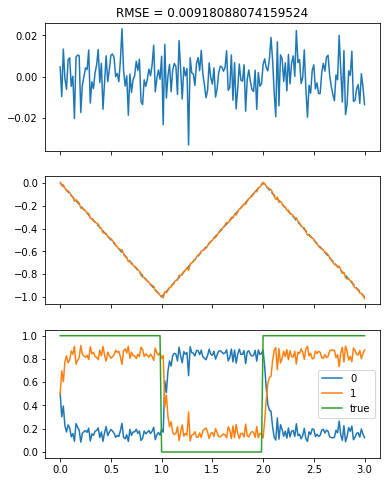

In [11]:
imm_x, imm_w, _ = run_imm()
plot_data(t,x,j,imm_x,imm_w);

In [12]:
smooth_x, smooth_w, loss = variable_projection(m)
plot_data(t,x,j,smooth_x,smooth_w[:,1]);

NameError: name 'FISTA' is not defined

In [ ]:
# store data for saving
no_resets={}
no_resets['true'] = {'t': copy.copy(t), 'x':copy.copy(x), 'w':copy.copy(j)}
no_resets['imm'] = {'x':copy.copy(imm_x), 'w':copy.copy(imm_w)}
no_resets['var_proj']={'x':copy.copy(smooth_x), 'w':copy.copy(smooth_w)}

## With resets

In [ ]:
t,x,j,m = sim_system(resets=True)

In [ ]:
imm_x, imm_w, _ = run_imm()
plot_data(t,x,j,imm_x,imm_w);

There is a tradeoff in terms of seperation of the discrete state and tracking the continuous state.

In [ ]:
largeq=.2
imm_x_largeq, imm_w_largeq, _ = run_imm(Q=largeq)
plot_data(t,x,j,imm_x_largeq,imm_w_largeq);

### Run our method

In [ ]:
smooth_x, smooth_w, loss = variable_projection(m)

In [ ]:
plot_data(t,x,j,smooth_x,smooth_w[:,1]);

## Larger jumps

The below is code in markdown so I (AP) can easily get in back if need be.

In [ ]:
t,x,j,m = sim_system(resets=True, reset_size=-5)

In [ ]:
imm_x, imm_w, _ = run_imm(Q=.001)

plot_data(t,x,j,imm_x,imm_w);

In [ ]:
largeq=.25
imm_x_largeq, imm_w_largeq, _ = run_imm(Q=largeq)
plot_data(t,x,j,imm_x_largeq,imm_w_largeq);

Notice how with a larger jump, a larger noise covariance is needed to track the continuous state, which causes less seperation between the estimated discrete states after the second jump and a longer delay in achieving the true discrete state after the first jump.

### Our method

In [ ]:
smooth_x, smooth_w, loss = variable_projection(m)

In [ ]:
plot_data(t,x,j,smooth_x,smooth_w[:,1]);

In [ ]:
# store data
resets={}
resets['true'] = {'t': copy.copy(t), 'x':copy.copy(x), 'w':copy.copy(j)}
resets['imm_q_001'] = {'x':copy.copy(imm_x), 'w':copy.copy(imm_w)}
resets['imm_q4'] = {'x':copy.copy(imm_x_largeq), 'w':copy.copy(imm_w_largeq)}
resets['var_proj']={'x':copy.copy(smooth_x), 'w':copy.copy(smooth_w)}

In [ ]:
1/0

## Save the data

In [ ]:
#save the data
output_folder = context.data_dir / "IMM_Comparison" / "Reset"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
header = '''
ground truth for simple switched system
switches at t=1 and t=5
'''
delim=','
fmt='%.10e'
t = resets['true']['t']
gnd_truth = np.hstack((resets['true']['t'][:,np.newaxis],resets['true']['x'],resets['true']['w'][:,np.newaxis]))
np.savetxt(output_folder/'gnd_truth.csv', gnd_truth, header=header, delimiter=delim, fmt=fmt)

imm = resets['imm_q_001']
imm_est = np.hstack([np.c_[t], imm['x'], imm['w']])
np.savetxt( output_folder/'imm_q.001.csv', imm_est,header=header, delimiter=delim, fmt=fmt)


imm = resets['imm_q4']
imm_est = np.hstack([np.c_[t], imm['x'], imm['w']])
np.savetxt( output_folder/('imm_q'+str(largeq)+'.csv'),imm_est, header=header, delimiter=delim, fmt=fmt)

vp = resets['var_proj']
vp_est = np.hstack([np.c_[t], vp['x'], vp['w']])
np.savetxt( output_folder/'var_proj.csv',vp_est, header=header, delimiter=delim, fmt=fmt)


In [ ]:
#save the data
output_folder = context.data_dir / "IMM_Comparison" / "NoReset"

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

In [ ]:
header = '''
ground truth for simple switched system
switches at t=1 and t=5
'''
delim=','
fmt='%.10e'
t = no_resets['true']['t']
gnd_truth = np.hstack((no_resets['true']['t'][:,np.newaxis],no_resets['true']['x'],no_resets['true']['w'][:,np.newaxis]))
np.savetxt(output_folder/'gnd_truth.csv', gnd_truth, header=header, delimiter=delim, fmt=fmt)

imm = no_resets['imm']
imm_est = np.hstack([np.c_[t], imm['x'], imm['w']])
np.savetxt( output_folder/'imm.csv', imm_est,header=header, delimiter=delim, fmt=fmt)


vp = no_resets['var_proj']
vp_est = np.hstack([np.c_[t], vp['x'], vp['w']])
np.savetxt( output_folder/'var_proj.csv',vp_est, header=header, delimiter=delim, fmt=fmt)